# **基于GPLinker的关系抽取实现**



## **训练前准备**

### 环境准备
安装tranformer包

In [ ]:
! pip install transformers

### 预训练模型下载

[RoBERTa中文预训练模型](https://drive.google.com/file/d/1yK_P8VhWZtdgzaG0gJ3zUGOKWODitKXZ/view)

将下载后的文件解压放入`./RoBERTa_zh_Large_PyTorch`文件夹。

注：也可修改`config.ini`中的路径，自行设置模型的存储位置。

## **训练**

导入所需的包或模块。

In [4]:
import torch
import json
import configparser
import numpy as np
from tqdm import tqdm
from zmq import device
from GPLinker import sparse_multilabel_categorical_crossentropy, GPLinker
from transformers import BertTokenizerFast, BertModel
from utils.data_loader import data_generator, load_name
from utils.bert_optimization import BertAdam
from torch.utils.data import DataLoader

读取config文件，获得数据集、预训练模型的路径及模型参数等信息。

In [5]:
con = configparser.ConfigParser()
con.read('./config.ini', encoding='utf8')
args_path = dict(dict(con.items('paths')), **dict(con.items("para"))) # 存储路径
print("========paths========")
for i in con.items('paths'):
  print(i[0],":",i[1])
print("========para========")
for i in con.items('para'):
  print(i[0],":",i[1])

========paths========
model_path : ./RoBERTa_zh_Large_PyTorch
train_file : ./datasets/CMeIE_train.json
val_file : ./datasets/CMeIE_dev.json
test_file : ./datasets/CMeIE_test.json
schema_data : ./datasets/53_schemas.json
========para========
maxlen : 256
batch_size : 10
epochs : 20
head_size : 64


导入预训练的RoBERTa模型，加载分词器、编码器。

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(args_path["model_path"], do_lower_case = True) #do_lower_case:区分大小写
encoder = BertModel.from_pretrained(args_path["model_path"])

读入关系。

In [7]:
with open(args_path["schema_data"],'r',encoding='utf-8') as f:
    schema = {} # 关系字典，键为关系，值为序号
    for idx,item in enumerate(f):
    # enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中。e.g. for i, element in enumerate(seq):  print i, element
        item = json.loads(item.rstrip()) 
        schema[item["subject_type"]+"_"+item["predicate"]+"_"+item["object_type"]] = idx
print("len_schema:",len(schema))

len_schema: 53


引入训练集、验证集，并对数据进行编码，设置迭代器。

In [8]:
train_data = data_generator(load_name(args_path["train_file"]),tokenizer=tokenizer,max_len=con.getint("para","maxlen"),schema=schema)
val_data = data_generator(load_name(args_path["val_file"]),tokenizer=tokenizer,max_len=con.getint("para","maxlen"),schema=schema)
test_data = data_generator(load_name(args_path["test_file"]),tokenizer=tokenizer,max_len=con.getint("para","maxlen"),schema=schema)
train_loader = DataLoader(train_data,batch_size=con.getint("para","batch_size"),shuffle=True, collate_fn=train_data.collate) #collate_fn：mini-batch生成方式
print("size of training set:", len(train_data))
print("size of validation set:", len(val_data))
print("size of test set:", len(test_data))

size of training set: 14339
size of validation set: 2008
size of test set: 1577


采用Hugging Face的Bert Adam优化器，并设置：
*   部分参数的权重衰减为$0.01$
*   学习率为$2e^{-5}$
*   学习率预热为$0.1$
*   梯度裁剪为$1$（默认值）

In [9]:
def set_optimizer(model, train_steps = None):
    param_optimizer = list(model.named_parameters())
    param_optimizer = [n for n in param_optimizer if 'pooler' not in n[0]]
    no_decay = ['bias','LayerNorm.bias','LayerNorm.weight']
    optimizer_grouped_parameters=[
        {
            'params':[p for n,p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay':0.01
        },
        {
            'params':[p for n,p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay':0.0
        }
    ]
    optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=0.1, t_total=train_steps)
    return optimizer

实例化网络、优化器。

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 调用cpu/gpu
net = GPLinker(encoder,len(schema)).to(device)
total_train_steps = (int(len(train_data)/con.getint("para","batch_size"))+1)*con.getint("para","epochs")
optimizer = set_optimizer(net,train_steps=total_train_steps)

引入进度条，可视化训练过程。

In [9]:
pbar = tqdm(total = total_train_steps)

  0%|          | 0/28680 [00:00<?, ?it/s]

定义训练时需要用的函数。

In [10]:
# 计算损失
def loss_calculator(logits1,logits2,logits3,batch_entity_labels,batch_head_labels,batch_tail_labels):
    # 根据评分，计算损失
    loss1 = sparse_multilabel_categorical_crossentropy(y_true=batch_entity_labels, y_pred=logits1, mask_zero=True)
    loss2 = sparse_multilabel_categorical_crossentropy(y_true=batch_head_labels,y_pred=logits2,mask_zero=True)
    loss3 = sparse_multilabel_categorical_crossentropy(y_true=batch_tail_labels,y_pred=logits3,mask_zero=True)
    loss = sum([loss1, loss2, loss3])/3
    return loss

# 推理，得出评分矩阵
def predict(net, batch):
    # 将经过Bert编码的一个batch读入
    text, batch_token_ids, batch_mask_ids,  batch_entity_labels, batch_head_labels, batch_tail_labels = batch
    # 将需要计算的数据to device
    batch_token_ids, batch_mask_ids,  batch_entity_labels, batch_head_labels, batch_tail_labels = \
        batch_token_ids.to(device), batch_mask_ids.to(device).to(
            device), batch_entity_labels.to(device), batch_head_labels.to(device), batch_tail_labels.to(device)
    # 计算评分
    logits1,logits2,logits3 = net(batch_token_ids,batch_mask_ids)
    return logits1,logits2,logits3,batch_entity_labels,batch_head_labels,batch_tail_labels

### 开始训练

In [11]:
tot_loss = []
for epoch in range(con.getint("para","epochs")):
    for idx, batch in enumerate(train_loader):
        net.train() 
        logits1,logits2,logits3,batch_entity_labels,batch_head_labels,batch_tail_labels = predict(net,batch) # 计算评分 
        loss = loss_calculator(logits1,logits2,logits3,batch_entity_labels,batch_head_labels,batch_tail_labels) #计算损失
        optimizer.zero_grad() # 清空梯度
        loss.backward() # 反向求导，计算梯度
        optimizer.step() # 对参数进行更新
        pbar.set_description("[EPOCH %d/%d] [LOSS:%f]" %(epoch, con.getint("para", "epochs"), loss.item()))
        pbar.update(1)
    tot_loss.append(loss)
    torch.save(net.state_dict(), 'result/GPLinker_para.pth')

/root/utils/bert_optimization.py:307: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
[EPOCH 19/20] [LOSS:0.070520]: 100%|██████████| 28680/28680 [2:56:21<00:00,  2.60it/s]    

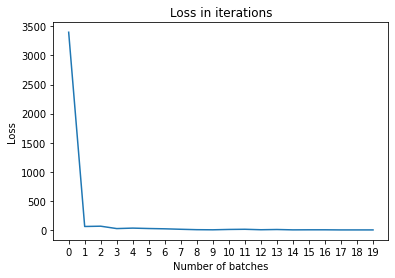

In [33]:
import matplotlib.pyplot as plt
b=[]
for i in range(len(tot_loss)):
    if  i % 1434 == 0:
        b.append(np.array(int(tot_loss[i])))
c = np.array(b)
x = np.arange(0,20,1)
y = np.array(c)
my_x_ticks = np.arange(20)
plt.xticks(my_x_ticks)
plt.plot(x,y)
plt.xlabel("Number of batches")
plt.ylabel("Loss")
plt.title("Loss in iterations")
plt.show()

## **效果评估** 
采用**F1-measure**的方式计算。

其中，
$$precision=\frac{TP}{TP+FP}$$
$$recall=\frac{TP}{TP+FN}$$
$$F1-measure = \frac{2\cdot precision\cdot recall}{precision+recall}$$

### 相关函数定义

查找$[h,t]$是否在列表lists中，用于后续的计算。

In [11]:
def search_list(h,t,lists):
    exist = False
    for s,e in lists:
        if s == h and t == e:
            exist = True
            break
    return exist

根据评分结果，提取出**subject**和**object**。

In [12]:
def find_s_o(outputs):
  subjects, objects = set(), set()
  outputs[0][:,[0,-1]] -= np.inf
  outputs[0][:,:,[0,-1]] -= np.inf
  for l, h, t in zip(*np.where(outputs[0] > 0)):
      if l == 0:
          subjects.add((h,t))
      else:
          objects.add((h,t))
  return subjects,objects

将预测结果转为GPlinker标签对应的形式，即**entity**、**head**、**tail**。

 
1.   **entity**：形状为$[2\times n \times 2]$，entity[0]为subject，entity[1]为object
2.   **head**：形状为$[\text{len(schema)}\times n \times 2]$，存储subject和object的head下标
3.   **tail**：形状为$[\text{len(schema)}\times n \times 2]$，存储subject和object的tail下标



In [13]:
def pred_result(subjects, objects, outputs):
  # 遍历subject、object的head和tail组合，如果对应关系得分大于0，则为预测结果。
  pred_head = [ []  for i in range(len(schema)) ]
  pred_tail = [ []  for i in range(len(schema)) ]
  pred_entity = [[] for i in range(2)]
  for s_h, s_t in subjects:
      for o_h, o_t in objects:
          p1s = np.where(outputs[1][:, s_h, o_h] > 0)[0]
          p2s = np.where(outputs[2][:, s_t, o_t] > 0)[0]
          ps = set(p1s) & set(p2s)
          for p in ps:
              if not search_list(s_h,o_h,pred_head[p]):
                  pred_head[p].append([s_h,o_h])
              if not search_list(s_t,o_t,pred_tail[p]):
                  pred_tail[p].append([s_t,o_t])
              if not search_list(s_h,s_t,pred_entity[0]):
                  pred_entity[0].append([s_h,s_t])
              if not search_list(o_h,o_t,pred_entity[1]):
                  pred_entity[1].append([o_h,o_t])
  return pred_head,pred_tail,pred_entity

分别求出**TP**、**TP+FP** 或 **TP+FN**。

In [14]:
def calculate_acc(entity,head,tail,head_com,tail_com,leng,true,total):
    subjects = entity[0]
    objects = entity[1]
    for s_h, s_t in subjects:
        for o_h, o_t in objects:
            for p in range(leng):
                if search_list(s_h,o_h,head[p]) and search_list(s_t,o_t,tail[p]):
                    total = total + 1
                    if search_list(s_h,o_h,head_com[p]) and search_list(s_t,o_t,tail_com[p]):
                        true = true + 1
    return true,total

定义评估函数。

In [15]:
def evaluate_F1(net,data):
    net.load_state_dict(torch.load('result/GPLinker_para.pth'))
    net.eval()
    data_loader = DataLoader(data,collate_fn=data.collate)
    with torch.no_grad():
        true1, true2, prediction, label= 0,0,0,0
        for idx, item in enumerate(data_loader):
            # 推理
            text, input_ids, attention_mask, entity_labels, head_labels, tail_labels = item
            input_ids, attention_mask= input_ids.clone().detach().to(device), attention_mask.clone().detach().to(device)
            entity_labels ,head_labels,tail_labels = entity_labels.squeeze(0),head_labels.squeeze(0),tail_labels.squeeze(0)
            scores = net(input_ids,attention_mask)
            outputs = [o.squeeze(0).cpu().numpy() for o in scores]
            # 找出subject、object
            subjects, objects = find_s_o(outputs)
            # 提取出预测结果
            pred_head, pred_tail, pred_entity = pred_result(subjects, objects, outputs)
            true1, prediction= calculate_acc(pred_entity,pred_head,pred_tail,head_labels,tail_labels,len(schema),true1,prediction)
            true2, label = calculate_acc(entity_labels,head_labels,tail_labels,pred_head,pred_tail,len(schema),true2, label)
        precision = true1/prediction
        recall = true2/label
        F1 = 2 * precision * recall/float(precision+recall)
        print("number of labels:", label)
        print("precision:", precision)
        print("recall：", recall)
        print("F1-measure：", F1)
    return F1

### **开始评估**

In [19]:
print("======training set======")
evaluate_F1(net,train_data)

======training set======
number of labels: 44006
precision: 0.9731675837239318
recall 0.976366859064673
F1-measure 0.9747645963155961


0.9747645963155961

In [17]:
print("======validation set======")
evaluate_F1(net,val_data)

======validation set======
number of labels: 6020
precision: 0.6506153023006955
recall 0.6064784053156146
F1-measure 0.6277720246670699


0.6277720246670699

In [18]:
print("======test set======")
evaluate_F1(net,test_data)

======test set======
number of labels: 4641
precision: 0.661178107606679
recall 0.6147382029734971
F1-measure 0.6371130117942115


0.6371130117942115